# Proyek Klasifikasi Gambar: [Garbage-Dataset]
- **Nama:** Ilham Sholahuddin
- **Email:** ilhamsholahuddin161@gmail.com
- **ID Dicoding:** ilham_sholahuddin16

## Import Semua Packages/Library yang Digunakan

In [1]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm as tq

In [2]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [3]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

## Data Preparation

In [4]:
# Import module untuk upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ilhamsholahuddin","key":"993e7ac291e8b62d67f22dbd11fb1726"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle*.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Download kaggle dataset
!kaggle datasets download -d sumn2u/garbage-classification-v2 -p /content/data

Dataset URL: https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2
License(s): MIT
 97% 725M/744M [00:02<00:00, 273MB/s]
100% 744M/744M [00:02<00:00, 366MB/s]


In [7]:
# Unzip Dataset
!unzip /content/data/garbage-classification-v2.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/garbage-dataset/paper/paper_847.jpg  
  inflating: /content/dataset/garbage-dataset/paper/paper_848.jpg  
  inflating: /content/dataset/garbage-dataset/paper/paper_849.jpg  
  inflating: /content/dataset/garbage-dataset/paper/paper_851.jpg  
  inflating: /content/dataset/garbage-dataset/paper/paper_852.jpg  
  inflating: /content/dataset/garbage-dataset/paper/paper_853.jpg  
  inflating: /content/dataset/garbage-dataset/paper/paper_855.jpg  
  inflating: /content/dataset/garbage-dataset/paper/paper_856.jpg  
  inflating: /content/dataset/garbage-dataset/paper/paper_857.jpg  
  inflating: /content/dataset/garbage-dataset/paper/paper_859.jpg  
  inflating: /content/dataset/garbage-dataset/paper/paper_861.jpg  
  inflating: /content/dataset/garbage-dataset/paper/paper_863.jpg  
  inflating: /content/dataset/garbage-dataset/paper/paper_865.jpg  
  inflating: /content/dataset/garbage-dataset/paper/paper_868.jpg

### Data Loading

**Data Exploration**

In [8]:
BASE_PATH = Path('/content/dataset/garbage-dataset')

for root, dirs, files in os.walk(BASE_PATH):
    if len(dirs) > 0 and len(files) == 0:
        data_dir = root
        break

print(f"Data directory: {data_dir}")
print(f"\nKelas yang tersedia:")

# Hitung jumlah gambar per kelas
classes = sorted(os.listdir(data_dir))
class_counts = {}

for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        class_counts[class_name] = count
        print(f"  - {class_name}: {count} gambar")

total_images = sum(class_counts.values())
print(f"\nTotal gambar: {total_images}")
print(f"Jumlah kelas: {len(class_counts)}")

Data directory: /content/dataset/garbage-dataset

Kelas yang tersedia:
  - battery: 944 gambar
  - biological: 997 gambar
  - cardboard: 1825 gambar
  - clothes: 5327 gambar
  - glass: 3061 gambar
  - metal: 1020 gambar
  - paper: 1680 gambar
  - plastic: 1984 gambar
  - shoes: 1977 gambar
  - trash: 947 gambar

Total gambar: 19762
Jumlah kelas: 10


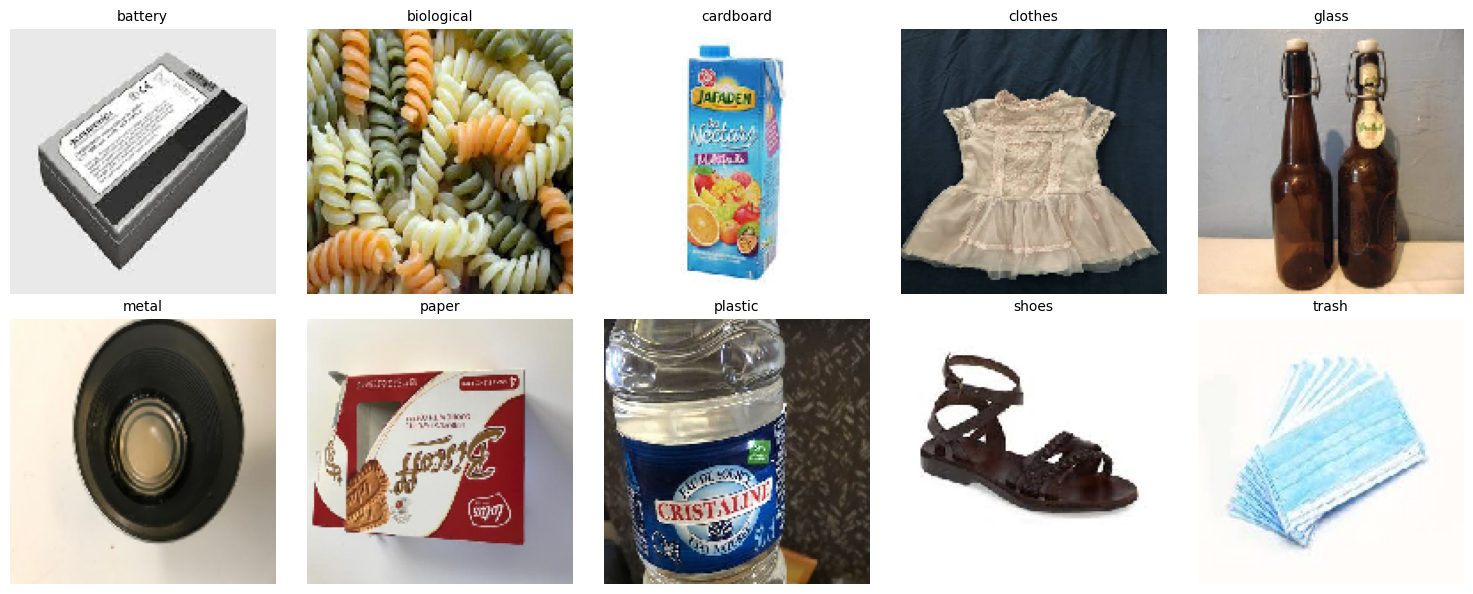

In [9]:
# Visualisasi sample gambar dari setiap kelas
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, class_name in enumerate(classes[:10]):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        if len(images) > 0:
            img_path = os.path.join(class_path, images[0])
            img = load_img(img_path, target_size=(150, 150))
            axes[i].imshow(img)
            axes[i].set_title(class_name, fontsize=10)
            axes[i].axis('off')

plt.tight_layout()
plt.show()

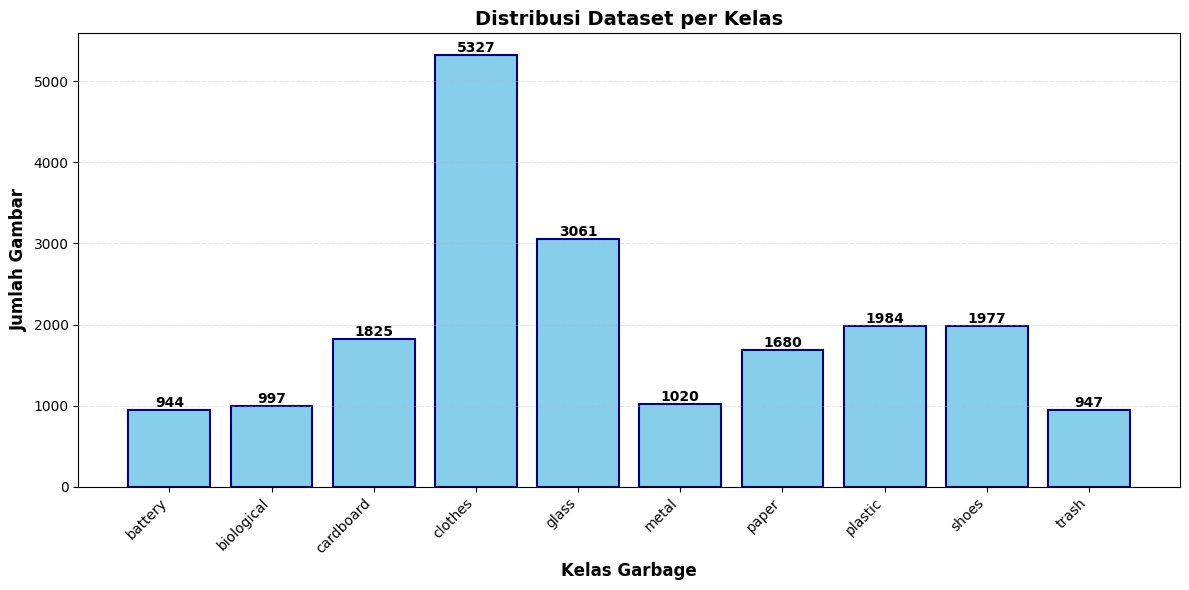

In [10]:
# Visualisasi distribusi kelas
plt.figure(figsize=(12, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color='skyblue', edgecolor='navy', linewidth=1.5)

# Tambahkan nilai di atas bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel('Kelas Garbage', fontsize=12, fontweight='bold')
plt.ylabel('Jumlah Gambar', fontsize=12, fontweight='bold')
plt.title('Distribusi Dataset per Kelas', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

### Data Preprocessing

#### Split Dataset

In [11]:
data_dir = "/content/dataset/garbage-dataset"
output_base = "/content/split_dataset"

TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
TEST_RATIO = 0.1

train_dir = f"{output_base}/train"
val_dir = f"{output_base}/val"
test_dir = f"{output_base}/test"

for p in [train_dir, val_dir, test_dir]:
    os.makedirs(p, exist_ok=True)

classes = sorted(os.listdir(data_dir))

print(" Splitting dataset...\n")

for cls in tq(classes):
    src = os.path.join(data_dir, cls)
    if not os.path.isdir(src):
        continue

    # buat folder kelas
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    images = [f for f in os.listdir(src) if f.lower().endswith(("jpg","png","jpeg"))]
    random.shuffle(images)

    n = len(images)
    n_train = int(n * TRAIN_RATIO)
    n_val = int(n * VAL_RATIO)

    train_imgs = images[:n_train]
    val_imgs   = images[n_train:n_train+n_val]
    test_imgs  = images[n_train+n_val:]

    # Copy images
    for img in train_imgs:
        shutil.copy2(os.path.join(src, img), os.path.join(train_dir, cls, img))

    for img in val_imgs:
        shutil.copy2(os.path.join(src, img), os.path.join(val_dir, cls, img))

    for img in test_imgs:
        shutil.copy2(os.path.join(src, img), os.path.join(test_dir, cls, img))

print(" Dataset splitting completed!")

 Splitting dataset...



  0%|          | 0/10 [00:00<?, ?it/s]

 Dataset splitting completed!


In [12]:
# Verify split
def count_files(directory):
    total = 0
    for root, dirs, files in os.walk(directory):
        total += len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    return total

train_count = count_files(train_dir)
val_count = count_files(val_dir)
test_count = count_files(test_dir)

print(f" Hasil Split:")
print(f" Train: {train_count} gambar ({train_count/total_images*100:.1f}%)")
print(f" Validation: {val_count} gambar ({val_count/total_images*100:.1f}%)")
print(f" Test: {test_count} gambar ({test_count/total_images*100:.1f}%)")
print(f" Total: {train_count + val_count + test_count} gambar")

 Hasil Split:
 Train: 13827 gambar (70.0%)
 Validation: 3949 gambar (20.0%)
 Test: 1986 gambar (10.0%)
 Total: 19762 gambar


#### Data Cleaning

In [13]:
# Folder Dataset hasil split
train_dir = "/content/split_dataset/train"
val_dir   = "/content/split_dataset/val"
test_dir  = "/content/split_dataset/test"

def scan_and_clean(folder):
    bad_files = []
    allowed_ext = (".jpg", ".jpeg", ".png", ".bmp", ".gif")

    for root, dirs, files in os.walk(folder):
        for f in files:
            path = os.path.join(root, f)

            # Skip jika ekstensi bukan standar
            if not f.lower().endswith(allowed_ext):
                bad_files.append(path)
                continue

            # Coba buka file
            try:
                img = Image.open(path)
                img.verify()   # check corrupt
            except:
                bad_files.append(path)

    print(f"\nFound {len(bad_files)} bad files:")
    for bf in bad_files:
        print(" -", bf)

    # auto delete
    for bf in bad_files:
        os.remove(bf)
    print("\nAll bad files removed!")


scan_and_clean(train_dir)
scan_and_clean(val_dir)
scan_and_clean(test_dir)


Found 0 bad files:

All bad files removed!

Found 0 bad files:

All bad files removed!

Found 0 bad files:

All bad files removed!


In [14]:
import os

for folder in [train_dir, val_dir, test_dir]:
    print("\nChecking:", folder)
    for root, dirs, files in os.walk(folder):
        for f in files:
            if not f.lower().endswith((".jpg",".jpeg",".png",".bmp",".gif")):
                print("Non-image file:", os.path.join(root, f))



Checking: /content/split_dataset/train

Checking: /content/split_dataset/val

Checking: /content/split_dataset/test


In [15]:
def check_rgba(folder):
    for root, dirs, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(".png"):
                p = os.path.join(root, f)
                try:
                    img = Image.open(p)
                    if img.mode != "RGB":
                        print("RGBA or Gray image:", p, "mode:", img.mode)
                except:
                    pass

check_rgba(train_dir)
check_rgba(val_dir)
check_rgba(test_dir)


RGBA or Gray image: /content/split_dataset/train/trash/trash_20243.png mode: RGBA
RGBA or Gray image: /content/split_dataset/train/trash/trash_20248.png mode: RGBA
RGBA or Gray image: /content/split_dataset/train/trash/trash_20245.png mode: RGBA
RGBA or Gray image: /content/split_dataset/train/trash/trash_20246.png mode: RGBA
RGBA or Gray image: /content/split_dataset/train/trash/trash_202410.png mode: RGBA
RGBA or Gray image: /content/split_dataset/train/trash/trash_20247.png mode: RGBA
RGBA or Gray image: /content/split_dataset/train/trash/trash_20249.png mode: RGBA
RGBA or Gray image: /content/split_dataset/train/clothes/clothes_20241.png mode: RGBA
RGBA or Gray image: /content/split_dataset/train/paper/paper_20242.png mode: RGBA
RGBA or Gray image: /content/split_dataset/train/paper/paper_20241.png mode: RGBA
RGBA or Gray image: /content/split_dataset/train/metal/metal_20241.png mode: RGBA
RGBA or Gray image: /content/split_dataset/train/metal/metal_20242.png mode: RGBA
RGBA or Gra

In [16]:
folders = [
    "/content/split_dataset/train",
    "/content/split_dataset/val",
    "/content/split_dataset/test"
]

print("Converting RGBA → RGB ...")

for folder in folders:
    for root, _, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(".png"):
                path = os.path.join(root, f)
                try:
                    img = Image.open(path)
                    if img.mode != "RGB":
                        print("Fixing:", path, "mode:", img.mode)
                        rgb = img.convert("RGB")
                        rgb.save(path)
                except Exception as e:
                    print("Error reading:", path, e)

print("\nAll RGBA images converted to RGB!")

Converting RGBA → RGB ...
Fixing: /content/split_dataset/train/trash/trash_20243.png mode: RGBA
Fixing: /content/split_dataset/train/trash/trash_20248.png mode: RGBA
Fixing: /content/split_dataset/train/trash/trash_20245.png mode: RGBA
Fixing: /content/split_dataset/train/trash/trash_20246.png mode: RGBA
Fixing: /content/split_dataset/train/trash/trash_202410.png mode: RGBA
Fixing: /content/split_dataset/train/trash/trash_20247.png mode: RGBA
Fixing: /content/split_dataset/train/trash/trash_20249.png mode: RGBA
Fixing: /content/split_dataset/train/clothes/clothes_20241.png mode: RGBA
Fixing: /content/split_dataset/train/paper/paper_20242.png mode: RGBA
Fixing: /content/split_dataset/train/paper/paper_20241.png mode: RGBA
Fixing: /content/split_dataset/train/metal/metal_20241.png mode: RGBA
Fixing: /content/split_dataset/train/metal/metal_20242.png mode: RGBA
Fixing: /content/split_dataset/train/metal/metal_20244.png mode: RGBA
Fixing: /content/split_dataset/train/metal/metal_20243.png 

In [17]:
def clean_tf_decode(root_dir):
    print(f"\n Checking TensorFlow decode compatibility in: {root_dir}\n")
    removed = 0
    checked = 0

    for folder, _, files in os.walk(root_dir):
        for file in files:
            path = os.path.join(folder, file)
            checked += 1

            try:
                raw = tf.io.read_file(path)
                _ = tf.io.decode_image(raw, channels=3)
            except:
                print(f"Removing corrupt file: {path}")
                removed += 1
                os.remove(path)

    print(f"\nDone scanning: {root_dir}")
    print(f"Total files checked: {checked}")
    print(f"Total removed: {removed}\n")
    return removed

# Jalankan untuk semua split
removed_train = clean_tf_decode(train_dir)
removed_val   = clean_tf_decode(val_dir)
removed_test  = clean_tf_decode(test_dir)

print(" FINAL SUMMARY")
print("Removed from train:", removed_train)
print("Removed from val:", removed_val)
print("Removed from test:", removed_test)


 Checking TensorFlow decode compatibility in: /content/split_dataset/train

Removing corrupt file: /content/split_dataset/train/paper/paper_1678.jpg
Removing corrupt file: /content/split_dataset/train/paper/paper_3119.jpg

Done scanning: /content/split_dataset/train
Total files checked: 13827
Total removed: 2


 Checking TensorFlow decode compatibility in: /content/split_dataset/val


Done scanning: /content/split_dataset/val
Total files checked: 3949
Total removed: 0


 Checking TensorFlow decode compatibility in: /content/split_dataset/test

Removing corrupt file: /content/split_dataset/test/paper/paper_2784.jpg

Done scanning: /content/split_dataset/test
Total files checked: 1986
Total removed: 1

 FINAL SUMMARY
Removed from train: 2
Removed from val: 0
Removed from test: 1


#### Load Dataset Preprocessing

In [18]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=True
)
raw_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=False
)
raw_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=False
)

class_names = raw_train_ds.class_names
num_classes = len(class_names)

print(class_names)

Found 13825 files belonging to 10 classes.
Found 3949 files belonging to 10 classes.
Found 1985 files belonging to 10 classes.
['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


#### Augmentasi + Normalisasi

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

def preprocess(ds, training=True):
    # Augmentasi untuk training saja
    if training:
        ds = ds.map(
            lambda x, y: (data_augmentation(x), y),
            num_parallel_calls=AUTOTUNE
        )

    # Normalisasi ke 0–1
    ds = ds.map(
        lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
        num_parallel_calls=AUTOTUNE
    )

    return ds.prefetch(AUTOTUNE)

train_ds = preprocess(raw_train_ds, training=True)
val_ds   = preprocess(raw_val_ds, training=False)
test_ds  = preprocess(raw_test_ds, training=False)

## Modelling

In [20]:
# Base model pretrained
base = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)
base.trainable = False

model = models.Sequential([
    layers.Input(shape=(224,224,3)),
    base,
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,136,394 (11.96 MB)

 Trainable params: 878,410 (3.35 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

#### Training Model

In [21]:
es = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor="val_loss"
)

lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=2,
    min_lr=1e-6
)

ckpt = tf.keras.callbacks.ModelCheckpoint(
    "mobilenetv2_stage1.keras",
    save_best_only=True,
    monitor="val_loss"
)

In [22]:
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[es, lr, ckpt]
)

Epoch 1/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 206s 421ms/step - accuracy: 0.6984 - loss: 0.9563 - val_accuracy: 0.8807 - val_loss: 0.4125 - learning_rate: 0.0010
Epoch 2/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 158s 364ms/step - accuracy: 0.8806 - loss: 0.4036 - val_accuracy: 0.8926 - val_loss: 0.3846 - learning_rate: 0.0010
Epoch 3/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 158s 364ms/step - accuracy: 0.8992 - loss: 0.3403 - val_accuracy: 0.8911 - val_loss: 0.3654 - learning_rate: 0.0010
Epoch 4/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 164s 378ms/step - accuracy: 0.9108 - loss: 0.2994 - val_accuracy: 0.8964 - val_loss: 0.3542 - learning_rate: 0.0010
Epoch 5/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 159s 365ms/step - accuracy: 0.9225 - loss: 0.2732 - val_accuracy: 0.9017 - val_loss: 0.3620 - learning_rate: 0.0010
Epoch 6/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 159s 366ms/step - accuracy: 0.9246 - loss: 0.2442 - val_accuracy: 0.9073 - val_loss: 0.3603 - learning_rate: 0.0010
Epoch 7/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 189s 435ms/step - accura

#### **Fine-Tune**

In [23]:
# Load Model Training awal
model = tf.keras.models.load_model("mobilenetv2_stage1.keras")
print("Loaded best initial model!")

Loaded best initial model!


In [24]:
# Unfreeze sebagian layer MobileNetV2
base_model = model.layers[0]
base_model.trainable = True

# Freeze sebagian besar layer bawah
for layer in base_model.layers[:-50]:
    layer.trainable = False

In [25]:
# Compile ulang dengan VERY LOW LR
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
# Callback untuk step Fine-Tune
ft_es = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

ft_ckpt = ModelCheckpoint(
    "best_model_final.keras",
    monitor='val_loss',
    save_best_only=True
)

ft_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.3,
    min_lr=1e-7
)

In [27]:
history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[ft_es, ft_lr, ft_ckpt]
)

Epoch 1/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 204s 414ms/step - accuracy: 0.8546 - loss: 0.5189 - val_accuracy: 0.9202 - val_loss: 0.3314 - learning_rate: 1.0000e-05
Epoch 2/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 166s 362ms/step - accuracy: 0.9058 - loss: 0.3250 - val_accuracy: 0.9169 - val_loss: 0.3228 - learning_rate: 1.0000e-05
Epoch 3/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 158s 364ms/step - accuracy: 0.9222 - loss: 0.2735 - val_accuracy: 0.9169 - val_loss: 0.3181 - learning_rate: 1.0000e-05
Epoch 4/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 158s 363ms/step - accuracy: 0.9264 - loss: 0.2490 - val_accuracy: 0.9197 - val_loss: 0.3150 - learning_rate: 1.0000e-05
Epoch 5/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 159s 364ms/step - accuracy: 0.9350 - loss: 0.2256 - val_accuracy: 0.9174 - val_loss: 0.3138 - learning_rate: 1.0000e-05
Epoch 6/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 203s 367ms/step - accuracy: 0.9424 - loss: 0.1985 - val_accuracy: 0.9172 - val_loss: 0.3062 - learning_rate: 1.0000e-05
Epoch 7/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 

## Evaluasi dan Visualisasi

#### **Plot Training vs Validation (Accuracy & Loss)**

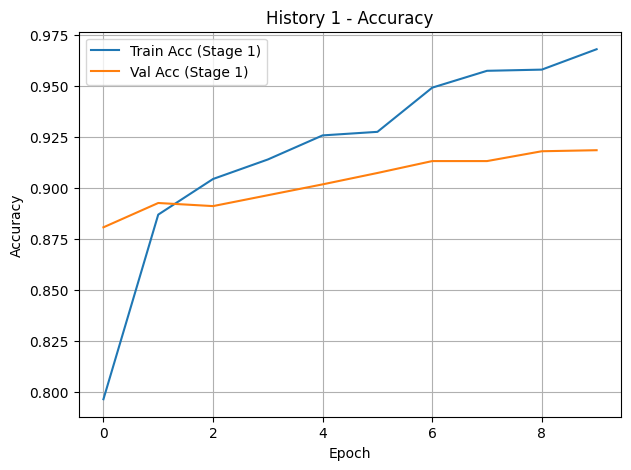

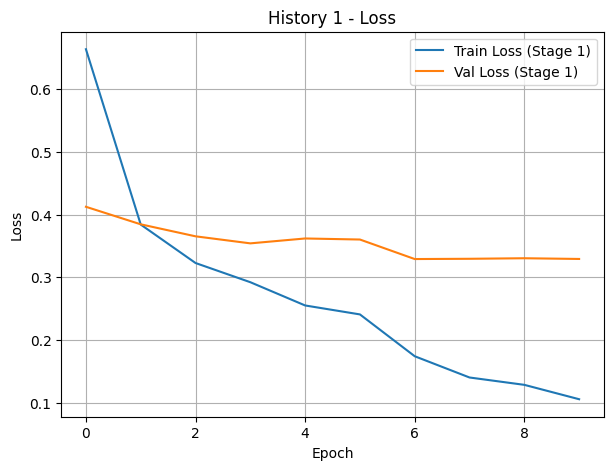

In [51]:
def plot_history(history1):
    # Training awal - Accuracy
    plt.figure(figsize=(7,5))
    plt.plot(history1.history['accuracy'], label='Train Acc (Stage 1)')
    plt.plot(history1.history['val_accuracy'], label='Val Acc (Stage 1)')
    plt.title("History 1 - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Training awal - Loss
    plt.figure(figsize=(7,5))
    plt.plot(history1.history['loss'], label='Train Loss (Stage 1)')
    plt.plot(history1.history['val_loss'], label='Val Loss (Stage 1)')
    plt.title("History 1 - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_history(history1)


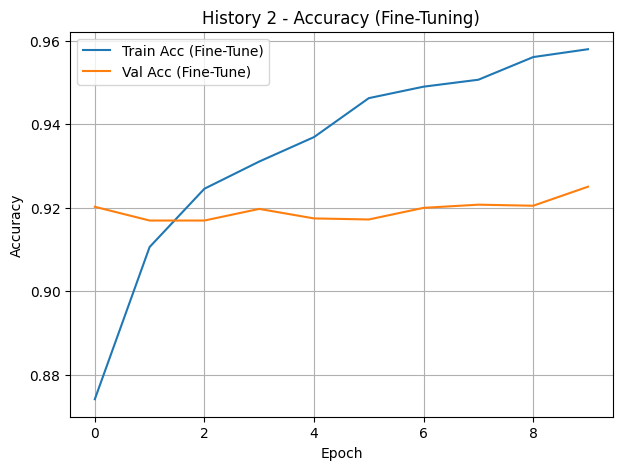

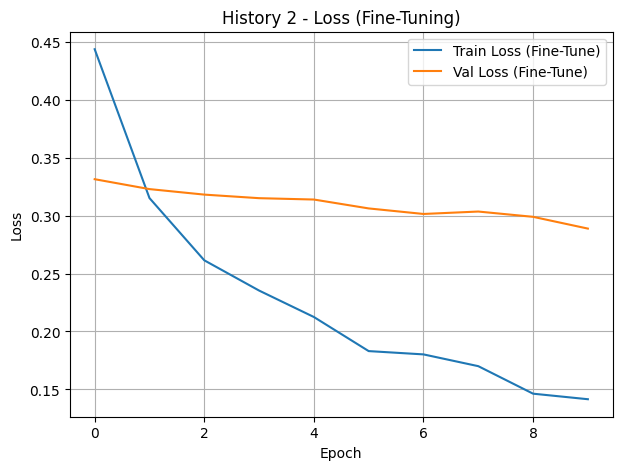

In [52]:
def plot_history_ft(history_ft):
 # Fine-Tuning - Accuracy
        plt.figure(figsize=(7,5))
        plt.plot(history_ft.history['accuracy'], label='Train Acc (Fine-Tune)')
        plt.plot(history_ft.history['val_accuracy'], label='Val Acc (Fine-Tune)')
        plt.title("History 2 - Accuracy (Fine-Tuning)")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()



        # fine Tuning - Loss
        plt.figure(figsize=(7,5))
        plt.plot(history_ft.history['loss'], label='Train Loss (Fine-Tune)')
        plt.plot(history_ft.history['val_loss'], label='Val Loss (Fine-Tune)')
        plt.title("History 2 - Loss (Fine-Tuning)")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()
plot_history_ft(history_ft)

#### **Evaluasi Model Final di Test Set**

In [53]:
test_loss, test_acc = model.evaluate(test_ds)
print("\n Final Test Accuracy:", test_acc)
print("Final Test Loss:", test_loss)

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9592 - loss: 0.1693

 Final Test Accuracy: 0.940554141998291
Final Test Loss: 0.2372085601091385


#### **Confusion Matrix**

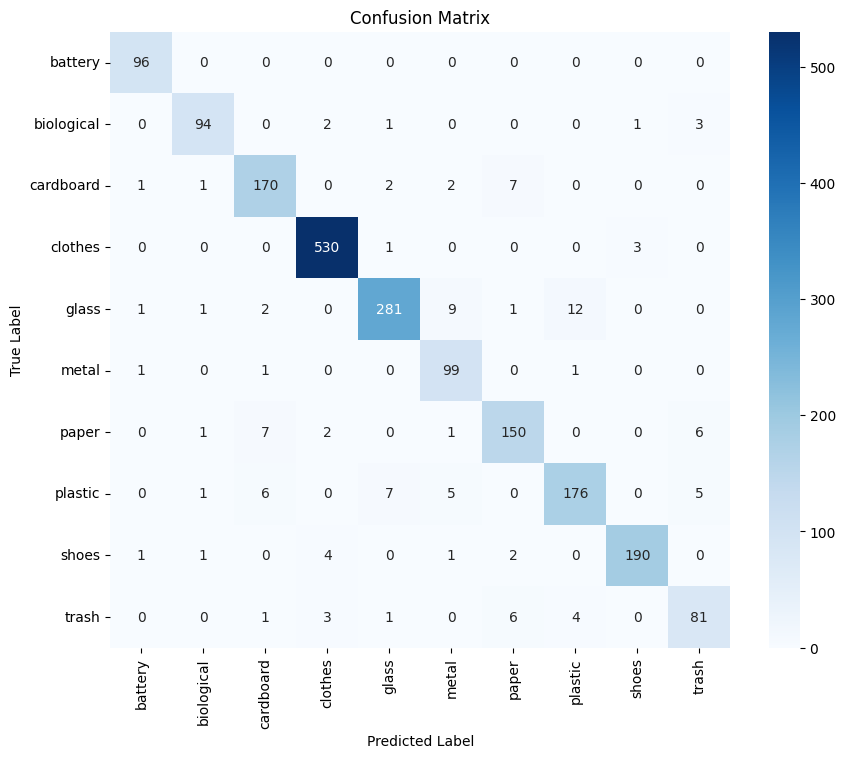

In [54]:
y_true = []
y_pred = []


for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, cmap='Blues', fmt='d')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

#### **Classification Report**

In [55]:
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:

              precision    recall  f1-score   support

     battery       0.96      1.00      0.98        96
  biological       0.95      0.93      0.94       101
   cardboard       0.91      0.93      0.92       183
     clothes       0.98      0.99      0.99       534
       glass       0.96      0.92      0.94       307
       metal       0.85      0.97      0.90       102
       paper       0.90      0.90      0.90       167
     plastic       0.91      0.88      0.90       200
       shoes       0.98      0.95      0.97       199
       trash       0.85      0.84      0.85        96

    accuracy                           0.94      1985
   macro avg       0.93      0.93      0.93      1985
weighted avg       0.94      0.94      0.94      1985



#### **Percobaan Prediksi Gambar**

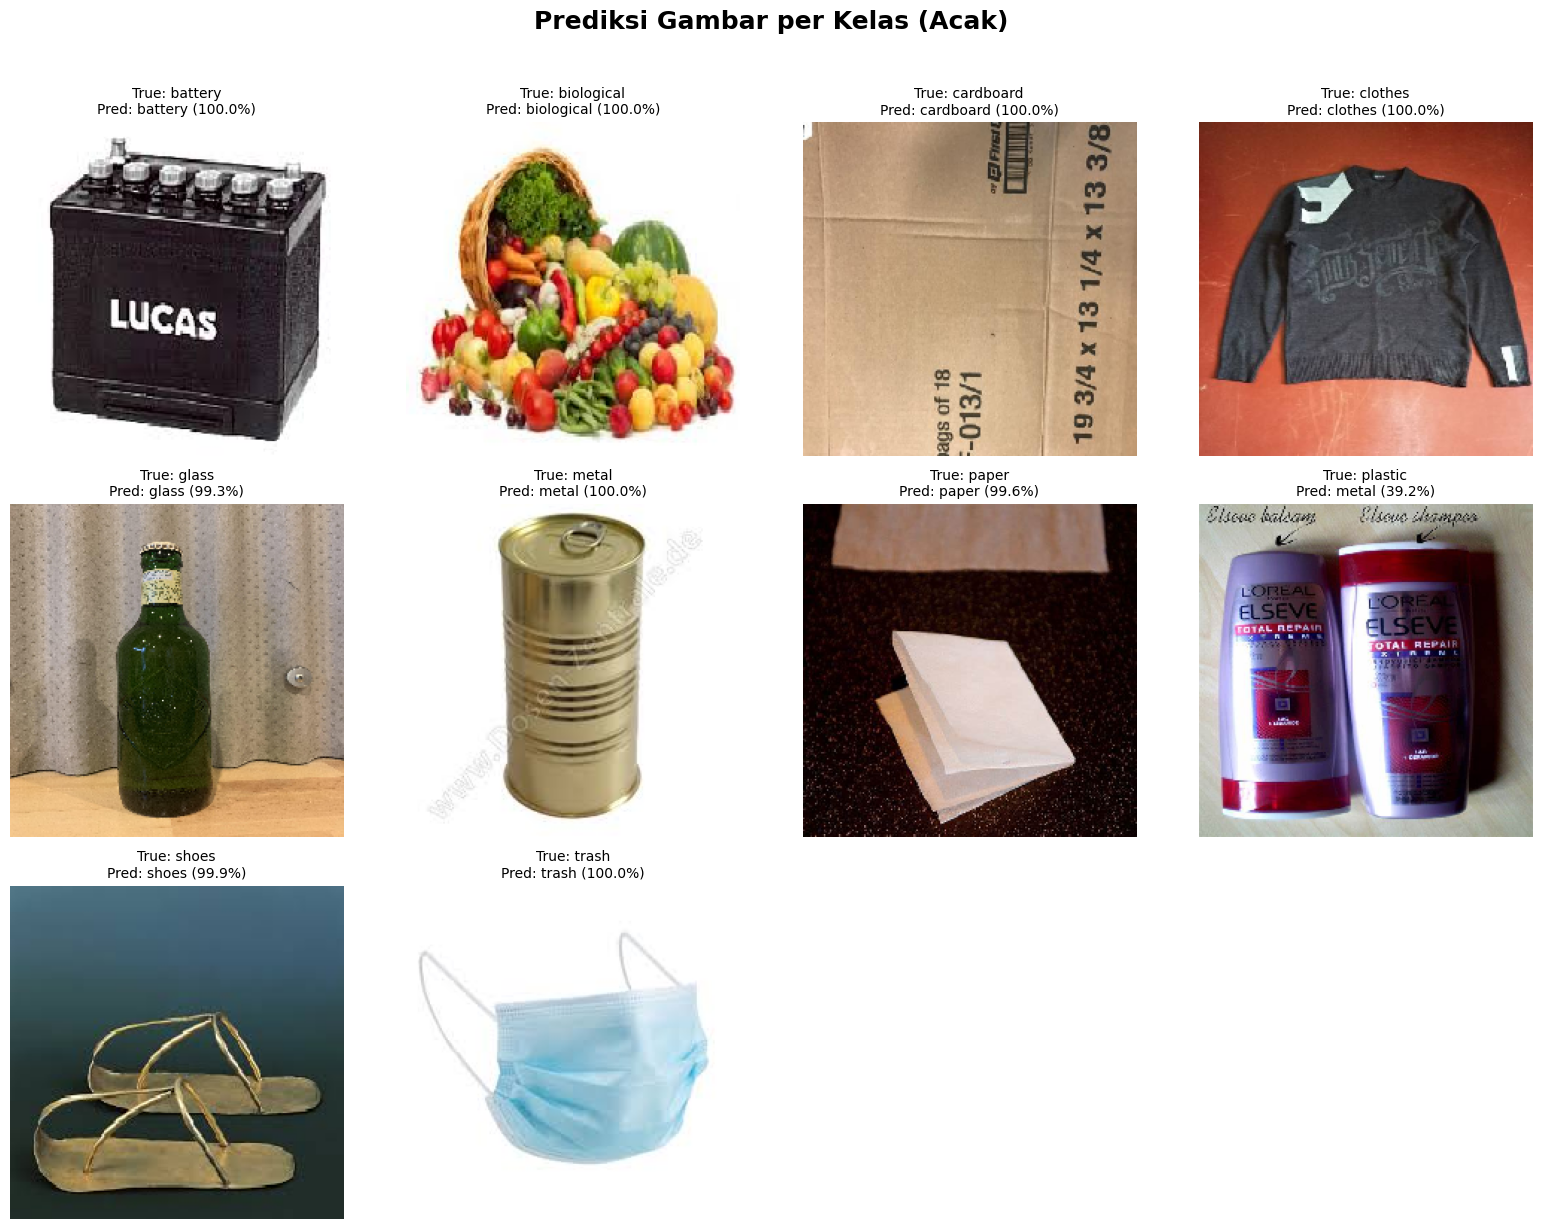

In [56]:
def predict_single_image(img_path):
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.cast(img_array, tf.float32) / 255.0

    predictions = model.predict(img_array, verbose=0)
    predicted_class_index = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    return predicted_class_index, confidence, img


# Plot sample predictions
num_classes = len(class_names)
rows = (num_classes // 4) + (1 if num_classes % 4 != 0 else 0)

plt.figure(figsize=(16, rows * 4))

for i, class_name in enumerate(class_names):
    class_path = os.path.join(test_dir, class_name)
    files = [f for f in os.listdir(class_path)
             if f.lower().endswith((".jpg", ".jpeg", ".png"))]

    if len(files) == 0:
        print(f"Tidak ada gambar untuk kelas: {class_name}")
        continue

    # Pilih Gambar Secara Acak
    img_path = os.path.join(class_path, random.choice(files))

    pred_idx, confidence, img = predict_single_image(img_path)

    plt.subplot(rows, 4, i+1)
    plt.imshow(img)
    plt.title(
        f"True: {class_name}\nPred: {class_names[pred_idx]} ({confidence*100:.1f}%)",
        fontsize=10
    )
    plt.axis("off")

plt.suptitle("Prediksi Gambar per Kelas (Acak)", fontsize=18, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

## Konversi Model

#### **SavedModel**

In [44]:
model.export("savedmodel_garbage_classifier")
print("SavedModel created!")

Saved artifact at 'savedmodel_garbage_classifier'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132012263374480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132012263361040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132012263366608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132012263374672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132012263366032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132012263363728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132011731157840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132011731157648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132012263362576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132012263374096: TensorSpec(shape=(), dtype=tf.resource, name=None)
 

#### **Convert ke TFLite**

In [47]:
converter = tf.lite.TFLiteConverter.from_saved_model("savedmodel_garbage_classifier")
tflite_model = converter.convert()

with open("garbage_model.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite created!")

TFLite created!


#### **Convert ke TensorFlow.js**

In [43]:
!pip install tensorflowjs

!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    savedmodel_garbage_classifier \
    tfjs_garbage_model

2025-11-15 12:18:15.003818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763209095.112593   24105 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763209095.133871   24105 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763209095.185087   24105 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763209095.185140   24105 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763209095.185149   24105 computation_placer.cc:177] computation placer alr

### **Inference menggunakan SavedModel**

Output keys: ['output_0']
Prediction: 7
Predicted label: plastic


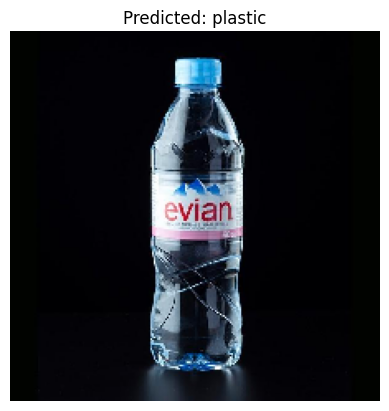

In [45]:
# Load savedmodel
loaded = tf.saved_model.load("/content/savedmodel_garbage_classifier")
infer = loaded.signatures["serving_default"]

# Check available keys
output_keys = list(infer.structured_outputs.keys())
print("Output keys:", output_keys)

# Use the first key (pasti softmax layer)
output_key = output_keys[0]

img_path = "/content/dataset/garbage-dataset/plastic/plastic_1027.jpg"

# Preprocess
img = image.load_img(img_path, target_size=(224, 224))
img_arr = image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0) / 255.0

# Run inference
output = infer(tf.constant(img_arr))[output_key].numpy()
pred_class = np.argmax(output)

print("Prediction:", pred_class)

plt.imshow(img)
print("Predicted label:", class_names[pred_class])
plt.title(f"Predicted: {class_names[pred_class]}")
plt.axis("off")
plt.show()

#### Ambil Library yang digunakan

In [46]:
!zip -r models1.zip /content/savedmodel_garbage_classifier

updating: content/savedmodel_garbage_classifier/ (stored 0%)
updating: content/savedmodel_garbage_classifier/saved_model.pb (deflated 90%)
updating: content/savedmodel_garbage_classifier/variables/ (stored 0%)
updating: content/savedmodel_garbage_classifier/variables/variables.index (deflated 78%)
updating: content/savedmodel_garbage_classifier/variables/variables.data-00000-of-00001 (deflated 7%)
updating: content/savedmodel_garbage_classifier/assets/ (stored 0%)
updating: content/savedmodel_garbage_classifier/fingerprint.pb (stored 0%)


In [50]:
!zip -r models.zip /content/tfjs_garbage_model

  adding: content/tfjs_garbage_model/ (stored 0%)
  adding: content/tfjs_garbage_model/group1-shard2of3.bin (deflated 7%)
  adding: content/tfjs_garbage_model/group1-shard1of3.bin (deflated 7%)
  adding: content/tfjs_garbage_model/model.json (deflated 96%)
  adding: content/tfjs_garbage_model/group1-shard3of3.bin (deflated 7%)


In [39]:
!pip freeze requirements.txt

absl-py==1.4.0
absolufy-imports==0.3.1
accelerate==1.11.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.2
aiosignal==1.4.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.17.1
altair==5.5.0
annotated-doc==0.0.4
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.11.0
anywidget==0.9.19
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.2
arrow==1.4.0
arviz==0.22.0
astropy==7.1.1
astropy-iers-data==0.2025.11.10.0.38.31
astunparse==1.6.3
atpublic==5.1
attrs==25.4.0
audioread==3.1.0
Authlib==1.6.5
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
beartype==0.22.5
beautifulsoup4==4.13.5
betterproto==2.0.0b6
bigframes==2.28.0
bigquery-magics==0.10.3
bleach==6.3.0
blinker==1.9.0
blis==1.3.0
blobfile==3.1.0
blosc2==3.11.0
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.2
brotli==1.2.0
build==1.3.0
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.10.5
cffi==2.0.0
chardet==5.2.0
charset-normalizer==